## Import modules and functions

In [1259]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import matplotlib.ticker as ticker

## Specify experiment directory

In [1260]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/201907-08_dio_ankgcy3_tnr647_stripped/' #master folder
protein="TNR" #TNR,Agg,WFA,HABP

## Make dictionary for storing results

In [1261]:
results = {"filename":[],
           "ecmchannelno":[],
           "diochannelno":[],
           "Manual axon mask from matlab GUI":[],
           "Manual neurites mask from matlab GUI":[],
           "exp condition":[],
           "ECM mean intensity after bg subtraction: matlab manual axon mask only":[],
           "ECM mean intensity after bg subtraction: matlab manual neurites mask only":[],
          "ECM mean int":[]}
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if filelist[i].endswith(".tif"): 
        if "unblocked" not in str(filelist[i]): 
            if str(filelist[i][:-12]) not in str(results["filename"]):
                results["filename"].append(filelist[i][:-12])
                results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                results["ecmchannelno"].append(3)
                results["diochannelno"].append(2)

## Display a random image

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: 201908_exp1_dio_ankgcy3_tnr647_stripped_Series10_z
Experimental condition: 201908_exp1_dio_ankgcy3_tnr647_stripped


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 8 Text yticklabel objects>)

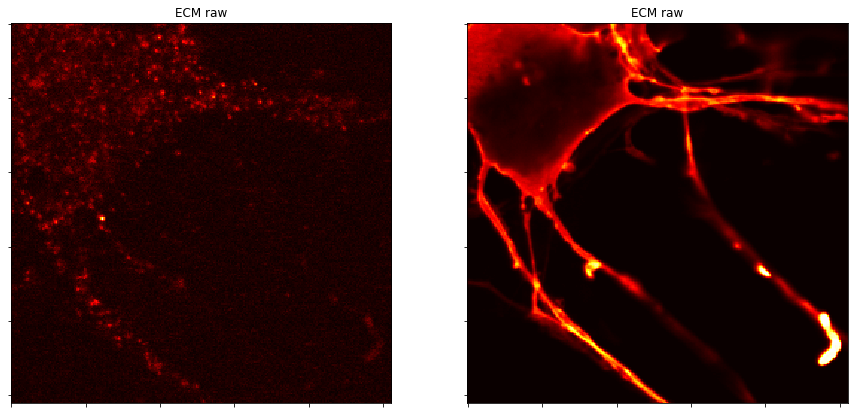

In [1262]:
import pims
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]

randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
ecm_image_name=results["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
dio_channel_no=results["diochannelno"][randomno]
dio_image_name=results["filename"][randomno]+"0_ch"+str(dio_channel_no-1)+"_t0.tif"
print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
dio_image=pims.open(dio_image_name)[0]

#bin
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)
ecm_image_bn=np.asarray(ecm_image)
ecm_image_bn=rebin(ecm_image,[256,256])
dio_image_bn=np.asarray(dio_image)
dio_image_bn=rebin(dio_image_bn,[256,256])

figure=plt.figure(figsize=(15,15))
figure.add_subplot(121)
plt.imshow(ecm_image_bn,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(122)
plt.imshow(dio_image_bn,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)

## Load manual masks for axon and dendrites made in Matlab GUI

In [1263]:
for im in range(0,len(results["filename"])): 
    file=results["filename"][im]+"0_ch0_t0_axonmask.mat"
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual axon mask from matlab GUI"].append(mask)
    else:
        results["Manual axon mask from matlab GUI"].append(np.nan)
        
    file=results["filename"][im]+"0_ch0_t0_dendritemask.mat"
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        if mask.any()==True:
            print('not empty')
        else:
            print('empty')
        results["Manual neurites mask from matlab GUI"].append(mask)
    else:
        results["Manual neurites mask from matlab GUI"].append(np.nan)
clear_output()        
print("Done!")

Done!


## Batch analyze the images

In [1264]:
flag=False
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    ecm_channel_no=results["ecmchannelno"][i]    
    ecm_image_name=results["filename"][i]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    ecm_image=pims.open(ecm_image_name)[0]

    #convert to numpy array - 
    ecm_image=np.array(ecm_image)
    ecm_image=np.divide(ecm_image,255.)
    results["ECM mean int"].append(np.nanmean(ecm_image))
    #read masks from matlab GUI
    matlab_axonmask=results["Manual axon mask from matlab GUI"][i]
    matlab_dendritesmask=results["Manual neurites mask from matlab GUI"][i]
    if type(matlab_dendritesmask)==np.ndarray:
        if type(matlab_axonmask)==np.ndarray:
            flag=True
    #background subtraction
    if flag==True:
        ecm_matlabaxonmasked_bgreduced=deepcopy(ecm_image)
        ecm_matlabdendritesmasked_bgreduced=deepcopy(ecm_image)
        
        bg_matlabaxonmask=np.mean(ndi.median_filter(ecm_image[matlab_axonmask],size=10))+0*np.std(ndi.median_filter(ecm_image[matlab_axonmask],size=5))
        ecm_matlabaxonmasked_bgreduced=np.subtract(ecm_matlabaxonmasked_bgreduced,bg_matlabaxonmask)
        ecm_matlabaxonmasked_bgreduced[ecm_matlabaxonmasked_bgreduced<0]=0
        ecm_matlabaxonmasked_bgreduced[~matlab_axonmask]=0
        
        bg_matlabdendritesmask=np.mean(ndi.median_filter(ecm_image[matlab_dendritesmask],size=10))+0*np.std(ndi.median_filter(ecm_image[matlab_dendritesmask],size=5))
        ecm_matlabdendritesmasked_bgreduced=np.subtract(ecm_matlabdendritesmasked_bgreduced,bg_matlabdendritesmask)
        ecm_matlabdendritesmasked_bgreduced[ecm_matlabdendritesmasked_bgreduced<0]=0
        ecm_matlabdendritesmasked_bgreduced[~matlab_dendritesmask]=0
    #add filtering by dio channel
    dio_channel_no=results["diochannelno"][i]    
    dio_image_name=results["filename"][i]+"0_ch"+str(dio_channel_no-1)+"_t0.tif"
    dio_image=pims.open(dio_image_name)[0]
    diomask=dio_image>0
    ecm_matlabaxonmasked_bgreduced[~diomask]=0
    ecm_matlabdendritesmasked_bgreduced[~diomask]=0
    #append the final results to the dictionary:
    
    if flag==True:
        results["ECM mean intensity after bg subtraction: matlab manual axon mask only"].append(np.nanmean(ecm_matlabaxonmasked_bgreduced[matlab_axonmask]))
        results["ECM mean intensity after bg subtraction: matlab manual neurites mask only"].append(np.nanmean(ecm_matlabdendritesmasked_bgreduced[matlab_dendritesmask]))
    else:
        results["ECM mean intensity after bg subtraction: matlab manual axon mask only"].append(np.nan)
        results["ECM mean intensity after bg subtraction: matlab manual neurites mask only"].append(np.nan)
    clear_output()
    flag=False
os.system('say "Finished batch analyzing"')
print('Done!')

Done!


## Make dataframe, remove outliers

In [1271]:
var3="ECM mean int"
df=pd.DataFrame(results)
#df=df[df[var1]<df[var1].quantile(.95)]
#df=df[df[var2]<df[var2].quantile(.95)]
#df=df[df[var3]<df[var3].quantile(.99)]
#dfexpsi=dfexpsi[dfexpsi["intensity"]<dfexpsi["intensity"].quantile(.99)]
#df=df[df["exp condition"]!="20190712_dio_ankgcy3_tnr647_stripped"]

In [1272]:
df2=deepcopy(df)
df2=df2.dropna()

In [1273]:
var1="ECM mean intensity after bg subtraction: matlab manual axon mask only"
var2="ECM mean intensity after bg subtraction: matlab manual neurites mask only"

axons=df2[var1].values
dendrites=df2[var2].values

[stati, pval]=stats.ttest_rel(axons,dendrites)
pval

0.2533765044214156

In [1274]:
print('axons: '+str(df2[var1].mean()*1000))
print('dendrites: '+str(df2[var2].mean()*1000))

axons: 3.0752391447896135
dendrites: 2.968730211723175


In [1275]:
df2[var2].mean()

0.0029687302117231747

<BarContainer object of 2 artists>

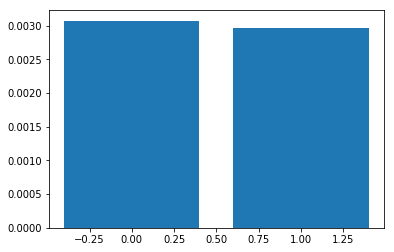

In [1276]:
plt.bar([0,1],[df2[var1].mean(),df2[var2].mean()])

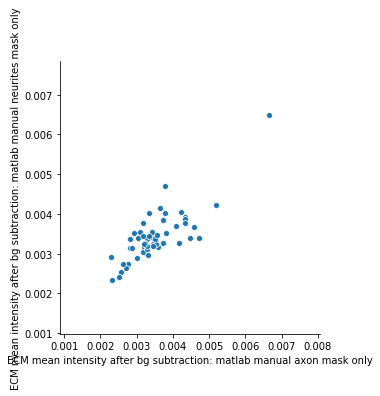

In [1194]:
sns.relplot(x=var1,y=var2,data=df2)

(0, 0.0045)

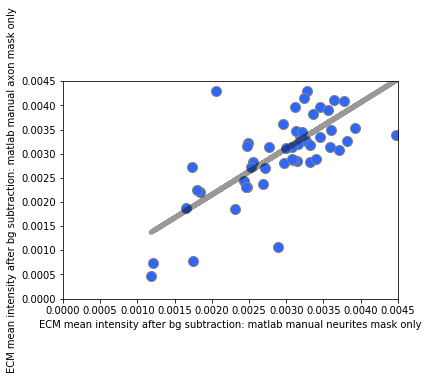

In [1277]:
df2plot=df2
g=sns.scatterplot(x=var2,
              y=var1,
                data=df2plot,s=100,color="#2F67F8",linewidth=1,edgecolor='grey')


#fit linear 
x=df2plot[var2].dropna()
y=df2plot[var1].dropna()
m,b = np.polyfit(x, y, 1) 
plt.plot( x, m*x+b, 'k',alpha=.4,linewidth=5) 
plt.ylim([0,0.0045])
plt.xlim([0,0.0045])

In [777]:
df["ratio"]=df[var2]/df[var1]

In [779]:
df["ratio"].median()

0.9031900827318669

## Dataframe for individual experiments

In [1278]:
var1="ECM mean intensity after bg subtraction: matlab manual axon mask only"
var2="ECM mean intensity after bg subtraction: matlab manual neurites mask only"

dfexps={"intensity":[],"dendrite or axon":[],"expname":[]}

for exp in df["exp condition"].unique():
    dfexp=df[df["exp condition"]==exp]
        
    dfexps["expname"].append(exp)
    dfexps["dendrite or axon"].append("axon")

    dfexps["intensity"].append(dfexp[var1].mean())

    dfexps["expname"].append(exp)
    dfexps["dendrite or axon"].append("dendrite")
    dfexps["intensity"].append(dfexp[var2].mean())
     
dfexpsi=pd.DataFrame(dfexps)

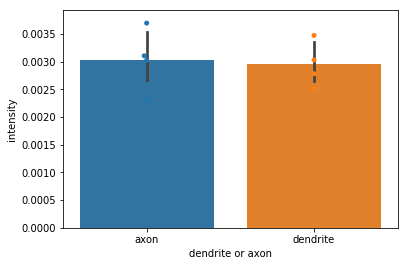

In [1279]:
sns.barplot(x="dendrite or axon",y="intensity",data=dfexpsi)
sns.swarmplot(x="dendrite or axon",y="intensity",data=dfexpsi)

## ttest

In [1010]:
import scipy
axonsi=dfexpsi[dfexpsi["dendrite or axon"]=="axon"]["intensity"].values
dendriteis=dfexpsi[dfexpsi["dendrite or axon"]=="dendrite"]["intensity"].values


[stat, pval]=scipy.stats.ttest_ind(axonsi, dendriteis)

In [1011]:
pval

0.48273877596198944

In [ ]:
df[]